gaussian
periodic
gaussianPeriodic


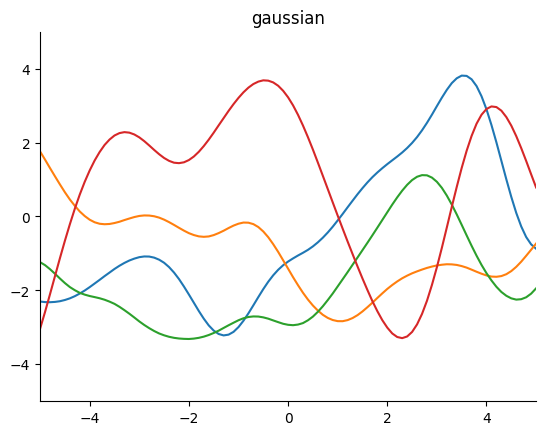

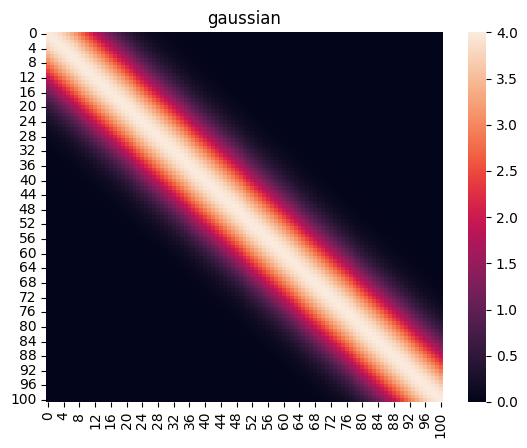

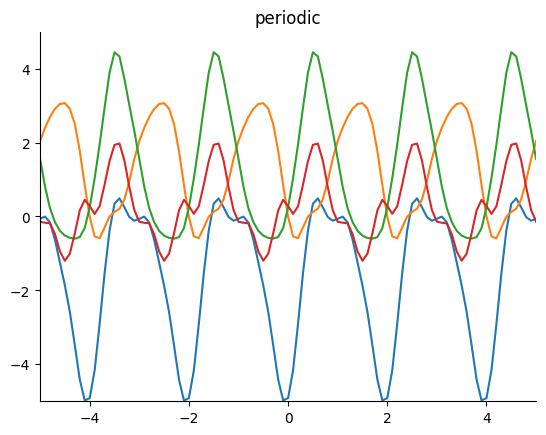

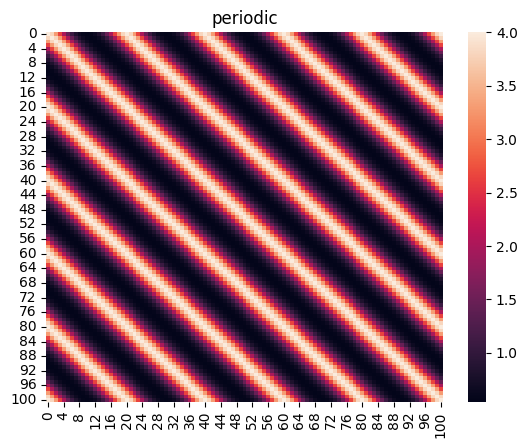

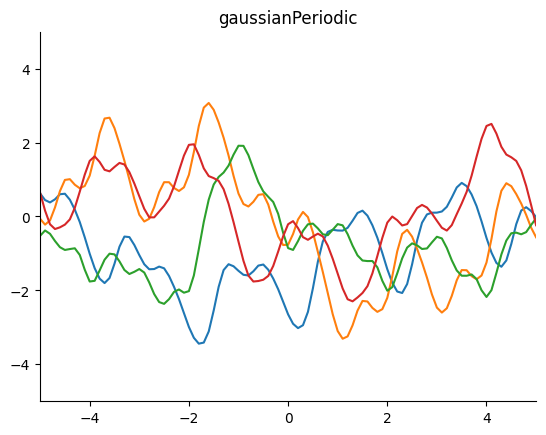

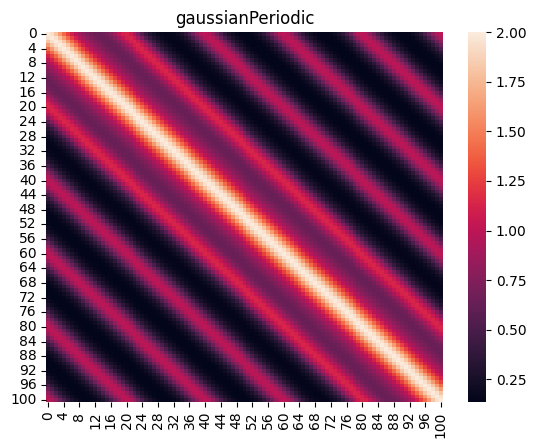

In [1]:
# Fig a in Fig 7.1 is almost the same with kernels.py in http://chasen.org/~daiti-m/gpbook/
# putil.py file in library folder is required for this code.

import library.putil as putil
import numpy as np
from numpy.random import multivariate_normal as mvnrand
import matplotlib.pyplot as plt
import seaborn as sns

xmax = 5
xmin = -5
ymax = 5
ymin = -5
M    = 4
N    = 101

SAVE_FILE = ""

def kgauss (params = (2.0, 1.0)):

    # H0 = 1
    [sigma, l] = params
    # (7.10)
    return lambda x,y: (sigma**2) * np.exp (-(x - y)**2 / (2 * (l**2)))

def kperiodic (params = (2.0, 1.0, 2.0)):
    [sigma, l, tPeriodic] = params

    #return lambda x,y: np.exp (tau * np.cos (np.abs(x - y) / sigma))
    # (7.15)
    return lambda x,y: (sigma**2) * np.exp (- (2 / l**2) * (np.sin(np.pi / tPeriodic * (x - y)))**2)

def kgaussPlusKperiodic (params = (1.0, 1.0, 1.0, 1.0, 2.0)):
    [sigmaGauss, lGauss, sigmaPeriodic, lPeriodic, tPeriodic] = params

    kgaussFunc = kgauss((sigmaGauss, lGauss))
    kperiodicFunc = kperiodic((sigmaPeriodic, lPeriodic, tPeriodic))

    # (7.16)
    return lambda x,y: kgaussFunc(x, y) + kperiodicFunc(x, y)

def kernel_matrix (xx, kernel):
    N = len(xx)
    eta = 1e-6

    # Return K
    # small offset for stability
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N) + eta * np.eye(N)

def fgp (xx, kernel):
    N = len(xx)
    K = kernel_matrix (xx, kernel)
    return mvnrand (np.zeros(N), K)

def fgpGetK(xx, kernel):
    K = kernel_matrix (xx, kernel)

    return K

def plotKernel(kernelName, kernelFunc):
    xx = np.linspace (xmin, xmax, N)

    fig = plt.figure()
    ax = fig.add_subplot()

    print(kernelName)
    for m in range(M):
        plt.plot (xx, fgp (xx, kernelFunc()))

    putil.simpleaxis ()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(kernelName)

    fig = plt.figure()
    ax = fig.add_subplot()
    sns.heatmap(fgpGetK (xx, kernelFunc()))
    ax.set_title(kernelName)

def main ():
    kernelName = ['gaussian', 'periodic', 'gaussianPeriodic']
    kernelFunc = [kgauss, kperiodic, kgaussPlusKperiodic]

    for kName, kFunc in zip(kernelName, kernelFunc):
        plotKernel(kName, kFunc)

    if len(SAVE_FILE) > 0:
        putil.savefig (SAVE_FILE)
    plt.show ()

if __name__ == "__main__":
    main ()

Text(0.5, 1.0, 'Samples function and data')

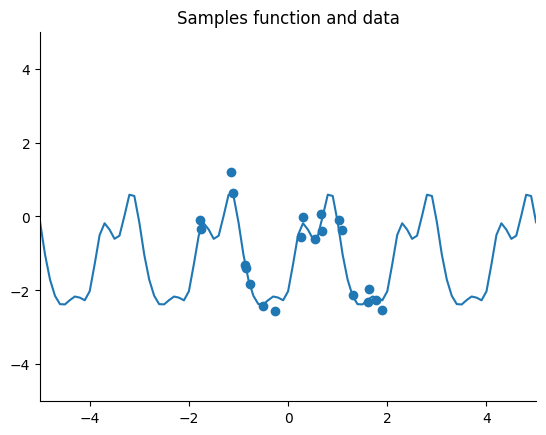

In [2]:
# Sample data points here
# We use eriodic kernel for sampling 

SAMPLE_NUM = 21
SAMPLE_XMIN = -2.0
SAMPLE_XMAX = 2.0

noizeBeta = 0.2

# xs for plot
xx = np.linspace (xmin, xmax, N)

# Select xs for samples
sampleXs = np.random.rand(SAMPLE_NUM) * (SAMPLE_XMAX - SAMPLE_XMIN) + SAMPLE_XMIN
#sampleXs = np.linspace (SAMPLE_XMIN, SAMPLE_XMAX, SAMPLE_NUM)

xsAll = np.concatenate([xx, sampleXs])
#print(xsAll)
kAll = fgpGetK(xsAll, kperiodic())
#print(kAll)

# Sample data
ysAll = mvnrand (np.zeros(len(xsAll)), kAll)
#print(ysAll)
yy = ysAll[0 : len(xx)]
sampleYs = ysAll[len(xx) : ] + noizeBeta * np.random.randn(SAMPLE_NUM)
#print(yy)
#print(sampleYs)

# Plot data
fig = plt.figure()
ax = fig.add_subplot()

plt.plot (xx, yy)
plt.scatter(sampleXs, sampleYs)

putil.simpleaxis ()

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title("Samples function and data")


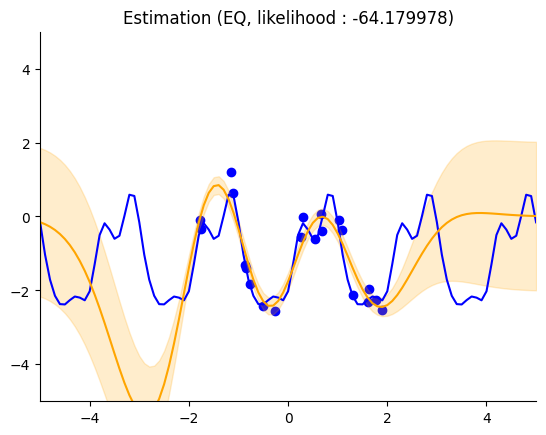

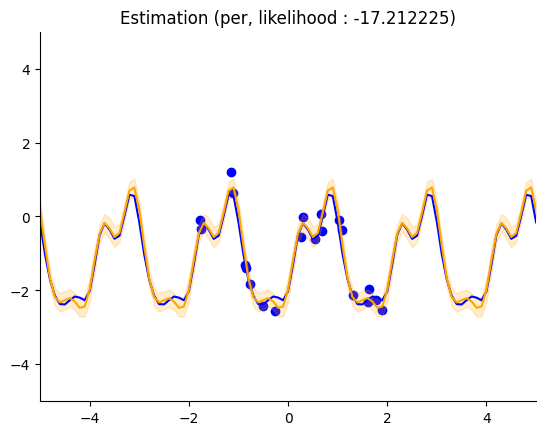

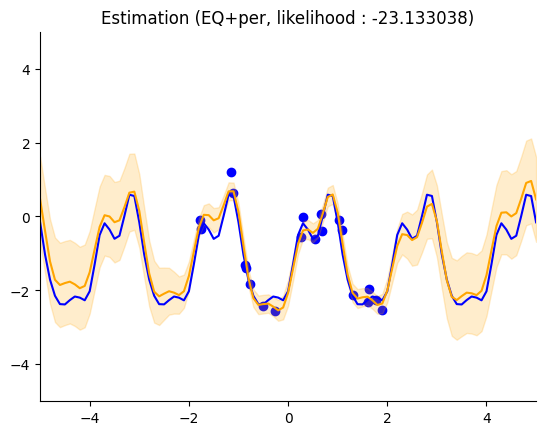

In [3]:
# Estimate the function using periodic kernel
kernels = [kgauss, kperiodic, kgaussPlusKperiodic]
kernelNames = ["EQ", "per", "EQ+per"]

for kernel, kernelName in zip(kernels, kernelNames):
    musPer = []
    sigmasPer = []
    sampleSize = len(sampleXs)

    for x in xx:
        xsEst = np.concatenate([sampleXs, [x]])
        kEst = fgpGetK(xsEst, kernel())
        kXX = kEst[0:sampleSize, 0:sampleSize] + noizeBeta**2 * np.eye(sampleSize)
        kXXInv = np.linalg.inv(kXX)
        kXestX = kEst[sampleSize, 0:sampleSize]

        # (7.9)
        musPer.append(kXestX.dot(kXXInv).dot(sampleYs))
        sigmasPer.append(np.sqrt(kEst[sampleSize, sampleSize] + noizeBeta**2 - kXestX.dot(kXXInv).dot(kXestX)))

    # Calculate likelihood
    kXX = fgpGetK(sampleXs, kernel()) + noizeBeta**2 * np.eye(sampleSize)
    kXXInv = np.linalg.inv(kXX)
    # (7.17)
    logLikelihood = -0.5 * (sampleYs.dot(kXXInv).dot(sampleYs) + np.log(np.linalg.det(kXX)) + sampleSize * np.log(2*np.pi))
    
    #print(musPer)
    #print(sigmasPer)
    musUpper = np.array(musPer) + np.array(sigmasPer)
    musBottom = np.array(musPer) - np.array(sigmasPer)

    # Plot data
    fig = plt.figure()
    ax = fig.add_subplot()

    plt.plot(xx, yy, color = "blue")
    plt.plot(xx, musPer, color = "orange")
    plt.scatter(sampleXs, sampleYs, color = "blue")
    ax.fill_between(xx, musUpper, musBottom, alpha = 0.2, color = "orange")

    putil.simpleaxis ()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title("Estimation (" + kernelName + ", likelihood : %f)" % logLikelihood)
